# Detecting Intruders Through Website Session Tracking  
_by Kavin Manickaraj_

## 0. The Problem

Storing a consumer's behavior data is quickly becoming the standard procedure for an ever-increasing number of industries, ranging from **banking**<sup>[1](http://www.bbc.com/storyworks/banking-on-innovation/bigdata)</sup> and **transportation**<sup>[2](https://datafloq.com/read/southwest-airlines-uses-big-data-deliver-excellent/371)</sup> to **fashion**<sup>[3](https://medium.com/datadriveninvestor/how-the-fashion-industry-is-using-data-science-33c9b2739ef6)</sup> and **food**<sup>[4](https://www.wsj.com/articles/how-restaurants-are-using-big-data-as-a-competitive-tool-1538515392)</sup>. But as we continue to tailor user experiences based on their prior histories, it becomes increasingly important to determine the _real_ users from the imposters.

In this article, we will explore one of the more obvious applications of this strategy by attempting to categorize web sessions between those of an authorized user surfing the web and those of a nefarious third-party hoping to sway customized results (such as ads and suggested content) away from the user's interests. Since the data used for this project is fictional, let's focus more on learning how different classifiers perform with this task and less on determining the optimal model or tuning hyper-parameters. Of course, implementing a full-scale approach would include the latter two components but that is beyond the scope of this study.  

To define our strategy more concretely, we will perform the following steps:
0. **Framing the problem** - _since we've defined the scope of work above, we can move along to..._
1. **Data pre-processing** - _where we import and clean the raw training data of errors, missing values, and unhelpful formats_
2. **Exploratory data analysis** - _during which we identify trends, select features, and create our final training datasets_
3. **Modeling and testing** - _the final component of this study at which time we'll weigh the benefits (and detriments) of various modeling strategies_

\*As an additional note, the data used in this study was obtained from [this Kaggle competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/data). The creators have specifically asked participants not to publish high-performing kernels. Therefore, this article will omit certain elements of that may be used to benefit a future participant's scores.


## 1. Data pre-processing

In [1]:
## We'll need the following libraries
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from scipy.sparse import hstack, csr_matrix
import xgboost as xgb
import time

## As a fan of FiveThirtyEight's visualizations, let's use their color schemes
plt.style.use('fivethirtyeight')

## Finally, let's quiet some of the warnings associated with some of the classifiers to keep our outputs clean
import warnings
warnings.filterwarnings('ignore')

As a necessary step to pre-processing the data, we will import the contents from `train_sessions.csv` into a Pandas dataframe and create column names. 

In [2]:
# load train data
train_data = pd.read_csv('../mlcourse.ai/data/train_sessions.csv')

# setting website and time column names - maximum 10 sessions
site_cols = ['site{}'.format(i) for i in range(1,11)]
time_cols = ['time{}'.format(i) for i in range(1,11)]

In [3]:
# function to name the dataframe columns
def convert_df(df):
    df[site_cols] = df[site_cols].fillna(0).astype('int')
    df[time_cols] = df[time_cols].apply(pd.to_datetime)
    return df

In [5]:
# use our function on our newly-imported data
train_data = convert_df(train_data)

# ...and print out the final shape of the DF
print('train_data shape: ', train_data.shape)

train_data shape:  (253561, 22)


Let's see what the dataframe looks like so far. This will help us identify other elements we'll need to fix during this data pre-processing stage.

In [6]:
train_data.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,0,NaT,0,NaT,0,NaT,0,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
1,2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,...,2014-02-22 11:19:51,3847,2014-02-22 11:19:52,3846,2014-02-22 11:19:52,1516,2014-02-22 11:20:15,1518,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,...,2013-12-16 16:40:19,14768,2013-12-16 16:40:20,14768,2013-12-16 16:40:21,14768,2013-12-16 16:40:22,14768,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,...,2014-03-28 10:54:42,782,2014-03-28 10:55:12,782,2014-03-28 10:55:42,782,2014-03-28 10:56:12,782,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 10:55:22,178,2014-02-28 10:55:23,177,...,2014-02-28 10:55:59,175,2014-02-28 10:55:59,177,2014-02-28 10:55:59,177,2014-02-28 10:57:06,178,2014-02-28 10:57:11,0


Immediately, we notice a few things:
- The `time1` column is not in chronological order
- We have `NaT` values where the user's session ended before visiting 10 websites

We address the former by sorting data with resect to the `time1` column. We can work on the `NaT` issue a bit later. For now, let's see how the newly-sorted dataframe looks.

In [7]:
train_data = train_data.sort_values(by=time_cols[0])
train_data.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
21668,21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54842,54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77291,77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114020,114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146669,146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


Separating the `target` column from the train_data as `y_train`

In [8]:
y_train = train_data.pop('target')
print('y_train shape: ', y_train.shape)

y_train shape:  (253561,)


In [9]:
print('New train_data shape: ', train_data.shape)

New train_data shape:  (253561, 21)


We have a pickle file that holds website information. Let's extract it and see what the dictionary holds

In [10]:
with open("../mlcourse.ai/data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Let's see the first 5 keys and values in the dictionary
print(list(site_dict.keys())[:5])
print(list(site_dict.values())[:5])

['www.abmecatronique.com', 'groups.live.com', 'majeureliguefootball.wordpress.com', 'cdt46.media.tourinsoft.eu', 'www.hdwallpapers.eu']
[25075, 13997, 42436, 30911, 8104]


To make a Dataframe with this information, we should set the dictionary keys as the dataframe values and vice versa.

In [11]:
sites_by_id = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
sites_by_id.head()

,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


Converting website data into Tf-Idf Vectorizer. This creates a sparse matrix where the output is weighed proportionally with the frequency of occurance of a text feature and inversely with the frequency of that feature over the corpus. Therefore, features that are too frequent and potentially unusable for distinguishing an example's outcome will be weighed appropriately. 

First, we need to replace the website IDs in each cell with the corresponding web addresses per the pickle dictionary

In [12]:
# Invert the site dictionary to be used when mapping the train/test site values
inverse_site_dict = {v: k for k,v in site_dict.items()}

In [13]:
train_sites = train_data[site_cols].apply(lambda col: col.map(inverse_site_dict))
test_sites = test_data[site_cols].apply(lambda col: col.map(inverse_site_dict))
train_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
21668,safebrowsing.clients.google.com,safebrowsing-cache.google.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54842,safebrowsing.clients.google.com,safebrowsing-cache.google.com,safebrowsing.clients.google.com,safebrowsing-cache.google.com,NaN,NaN,NaN,NaN,NaN,NaN
77291,www.apache.org,www.apache.org,download.eclipse.org,www.apache.org,www.apache.org,www.webtide.com,download.oracle.com,javadl-esd-secure.oracle.com,www.caucho.com,www.apache.org
114020,www.webtide.com,download.oracle.com,www.caucho.com,download.oracle.com,www.webtide.com,www.apache.org,public.dhe.ibm.com,www.webtide.com,www.apache.org,www.apache.org
146669,public.dhe.ibm.com,jope.ow2.org,download.oracle.com,public.dhe.ibm.com,jope.ow2.org,master.dl.sourceforge.net,www.apache.org,download.eclipse.org,www.apache.org,public.dhe.ibm.com


Fill `NaN` values with `0` and output a CSV file. This step allows us to take advantage of OHE vectorizer operations.

In [14]:
train_sites.fillna(0).to_csv('train_sites.txt', sep=' ', index=False, header=False)
test_sites.fillna(0).to_csv('test_sites.txt', sep=' ', index=False, header=False)

whole_sites = pd.concat([train_sites, test_sites])
whole_sites.fillna(0).to_csv('whole_sites.txt', sep=' ', index=False, header=False)

Let's use a Tf-Idf vectorizer to identify the most useful website name features while ignoring those that are too prevalent and therefore not distinctive to either authorized and unauthorized users. We set the n-grams between 1 and 4 to capture a range of sites that may have multiple word components.

In [15]:
%%time
tv = TfidfVectorizer(ngram_range=(1,4), analyzer='word', max_features=50000) ## choosing the 10,000 most frequent feat

with open('whole_sites.txt') as input_whole:
    tv_whole_fit = tv.fit(input_whole)

Wall time: 36.1 s


In [16]:
with open('train_sites.txt') as input_train:
    train_tfidf = tv.transform(input_train)
with open('test_sites.txt') as input_test:
    test_tfidf = tv.transform(input_test)

In [17]:
print('train_tfidf shape is: {} \ntest_tfidf shape is {}'.format(train_tfidf.shape, test_tfidf.shape))

train_tfidf shape is: (253561, 50000) 
test_tfidf shape is (82797, 50000)


In [18]:
print(type(train_tfidf), type(test_tfidf))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>


Now we have a sparse matrix `train_tfidf` that captures the top 50,000 features vectorized by word n-grams describing web addresses. We don't have labels for the 'test_tfidf' matrix, but we can still run our model on the data to see the probabilites of sessions being authorized or unauthorized.

Our next step is to add time-dependent features. To do this, let's create a new sparse matrix of some basic time data we want to visualize. Some basic pieces information we'd like to investigate are:

- start hour
- stop hour
- start day
- start month
- year
- total session minutes

In [19]:
def add_time_features(dataframe, scaler):
    ''' This function takes a dataframe and a scaler function (or a pipeline of transformers) 
    and outputs a dataframe of extracted time features as well as a transformed/scaled 
    dataframe defined by the scalers provided.'''
    
    df = pd.DataFrame(index=dataframe.index)
    t = 'time1'
    df['start_hour'] = dataframe[t].apply(lambda ts: ts.hour)
    df['stop_hour'] = dataframe[time_cols].max(axis=1).apply(lambda ts: ts.hour)
    df['start_day'] = dataframe[t].apply(lambda ts: ts.weekday())
    df['start_month'] = dataframe[t].apply(lambda ts: ts.month)
    df['year'] = dataframe[t].apply(lambda ts: ts.year)
    df['session_mins'] = round((dataframe[time_cols].max(axis=1) - 
                                dataframe[time_cols].min(axis=1)) 
                               /np.timedelta64(1, 'm'), 2)
    df_scaled = pd.DataFrame(scaler.fit_transform(df),
                             index=df.index,
                             columns=df.columns)
    return df, df_scaled

In [20]:
pipeline = Pipeline([('sscaler', StandardScaler())])
train_times, train_times_scaled = add_time_features(train_data, pipeline)
print(train_times.shape)
train_times_scaled.head()

(253561, 6)


,start_hour,stop_hour,start_day,start_month,year,session_mins
21668,-1.357366,-1.365219,1.682905,-0.943567,-1.547749,-0.468233
54842,-1.357366,-1.049528,1.682905,-0.943567,-1.547749,5.570684
77291,-1.357366,-1.365219,1.682905,-0.943567,-1.547749,-0.454034
114020,-1.357366,-1.365219,1.682905,-0.943567,-1.547749,-0.458091
146669,-1.357366,-1.365219,1.682905,-0.943567,-1.547749,-0.462148


We can concatenate the resulting scaled time-feature dataframe with the 'train_tfidf' data and produce a set of data with a combined 50,006 features to be analyzed with our model. This may not be our final dataset to be considered, but we'll save it now to compare against the results of other dataframes with different features we'll build. 

In [21]:
train_sparse = hstack((train_tfidf, csr_matrix(train_times_scaled)))
train_sparse.shape

(253561, 50006)

### Visualizing Features

In [22]:
train_times['target'] = y_train
train_times.head()

,start_hour,stop_hour,start_day,start_month,year,session_mins,target
21668,8,8,5,1,2013,0.00,0
54842,8,9,5,1,2013,29.77,0
77291,8,8,5,1,2013,0.07,0
114020,8,8,5,1,2013,0.05,0
146669,8,8,5,1,2013,0.03,0


In [23]:
print('Min start hour: {}; Max start hour: {} \nMin stop hour: {}, Max start hour: {}'
      .format(train_times.start_hour.min(),
              train_times.start_hour.max(),
              train_times.stop_hour.min(),
              train_times.stop_hour.max()))

Min start hour: 7; Max start hour: 23 
Min stop hour: 7, Max start hour: 23


Wall time: 38 s


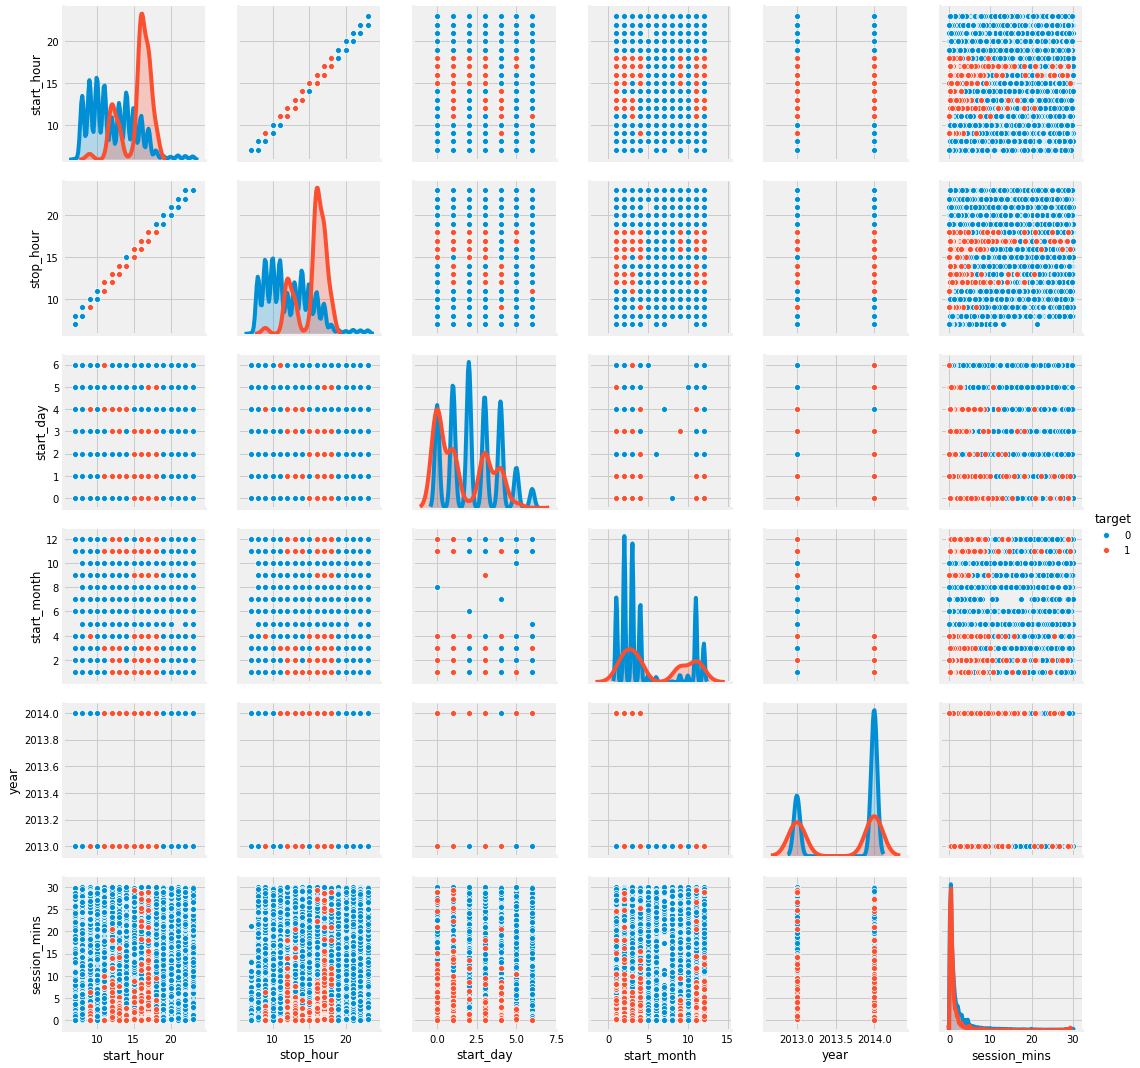

In [24]:
%%time
sns.pairplot(train_times, vars=list(train_times.columns)[:-1], hue='target', height=2.5)

It seems like our data can benefit from some polynomial features -- specifically for the features `session_mins`, `start_hour`, `start_month`, `start_day`.
This is because the target values do not seem linearly separable without polynomial considerations.

In [25]:
def add_poly_feats(dataframe):
    feat_list = ['session_mins', 'start_hour', 'start_month', 'start_day']
    pipeline = Pipeline([('poly', PolynomialFeatures(2, include_bias=False)), ('sscaler', StandardScaler())])
    values = pipeline.fit_transform(dataframe[feat_list])
    df_scaled = pd.DataFrame(values, index=dataframe.index)
    return df_scaled[list(range(4,len(df_scaled.columns)))]

In [26]:
poly_train_times = add_poly_feats(train_times)
poly_train_times.head()

,4,5,6,7,8,9,10,11,12,13
21668,-0.259557,-0.435987,-0.336844,-0.355233,-1.141548,-0.938987,0.505361,-0.669589,-0.433697,1.990254
54842,7.503990,3.136628,0.587071,9.698256,-1.141548,-0.938987,0.505361,-0.669589,-0.433697,1.990254
77291,-0.259514,-0.427586,-0.334672,-0.331594,-1.141548,-0.938987,0.505361,-0.669589,-0.433697,1.990254
114020,-0.259535,-0.429987,-0.335292,-0.338348,-1.141548,-0.938987,0.505361,-0.669589,-0.433697,1.990254
146669,-0.259549,-0.432387,-0.335913,-0.345102,-1.141548,-0.938987,0.505361,-0.669589,-0.433697,1.990254


Make this a sparse matrix and add it to our existing `train_sparse` to form `train_poly_sparse`

In [27]:
train_poly_sparse = hstack([train_sparse, csr_matrix(poly_train_times)])
print(type(train_poly_sparse), train_poly_sparse.shape)

<class 'scipy.sparse.coo.coo_matrix'> (253561, 50016)


As an alternative to considering all of the time features without a "human interpretation" , let's try looking at the time data once more with time-of-day classifications such as 'morning', 'afternoon', 'evening', and 'night'. A machine learning algorithm may not understand the importance of these seemingly arbitrary classifcations, but knowing that most people operate their days within general time-frames such as these may help us further interpret data trends.

In [28]:
def add_time_of_day_features(dataframe):
    '''Takes a dataframe, extracts the starting hour, and inteprets the time of day.
     This function outputs a DataFrame with OHE vectorized data corresponding to the time of day defined as:
    "morning"
    "afternoon"
    "evening"
    
    We can skip a "night" classification because there is no web usage between 23:00 and 7:00
    '''
    
    df = pd.DataFrame(index=dataframe.index)
    hour = dataframe['time1'].apply(lambda ts: ts.hour)
    df['morning'] = ((hour >= 7) & (hour <= 11)).astype('int') # between 7:00 and 11:00
    df['afternoon'] = ((hour >= 12) & (hour <= 17)).astype('int') # between 12:00 and 17:00
    df['evening'] = ((hour >= 18) & (hour <= 23)).astype('int') # between 18:00 and 23:00
    
    df_labels = pd.DataFrame(index=dataframe.index, 
                             data=np.dot(df.values, np.array(df.columns)), 
                             columns=['TOD'])
    
    return df, df_labels

In [29]:
train_tod_ohe, train_tod_labels = add_time_of_day_features(train_data)
train_tod_labels['target'] = y_train
train_tod_labels.head()

,TOD,target
21668,morning,0
54842,morning,0
77291,morning,0
114020,morning,0
146669,morning,0


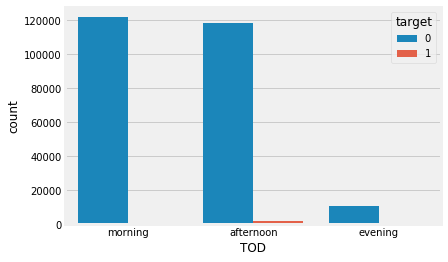

In [30]:
sns.countplot(x = 'TOD', hue = 'target', data = train_tod_labels)

From this visualization, we can determine two things:
1. The authorized user primarily surfs the web in the afternoon.
2. The data is imbalanced heavily towards unauthorized usage (label 0).

One more piece of time-based information to notice is that the authorized user's monthly activity excludes the months May-August. Similar to creating human-interpretable hourly bins above, let's create monthly bins associated with two "working" semesters and one "summer" semester.

First, let's verify the months during which the authorized user has surfed the web.

In [31]:
print('Authorized user\'s web-surfing months are: {}'
      .format(np.sort(train_times[train_times.target==1].start_month.unique())))

Authorized user's web-surfing months are: [ 1  2  3  4  9 11 12]


In [32]:
def add_time_of_year_features(dataframe):
    df = pd.DataFrame(index=dataframe.index)
    month = dataframe['time1'].apply(lambda ts: ts.month)
    df['spring'] = ((month >= 1) & (month <= 4)).astype('int') # Months 1-4
    df['summer'] = ((month >= 5) & (month <= 8)).astype('int') # Months 5-8
    df['fall'] = ((month >= 9) & (month <= 12)).astype('int') # Months 9-12
    
    df_labels = pd.DataFrame(index=dataframe.index, 
                             data=np.dot(df.values, np.array(df.columns)), 
                             columns=['TOY'])    
    
    return df, df_labels
    

In [33]:
train_toy_ohe, train_toy_labels = add_time_of_year_features(train_data)
train_toy_labels['target'] = y_train
train_toy_labels.head()

,TOY,target
21668,spring,0
54842,spring,0
77291,spring,0
114020,spring,0
146669,spring,0


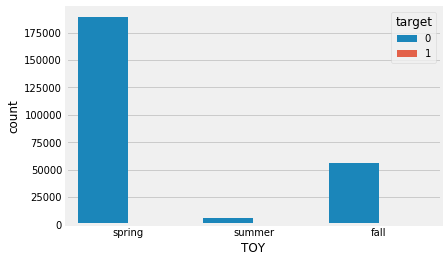

In [34]:
sns.countplot(x = 'TOY', hue = 'target', data = train_toy_labels)

Now that we have some "human-interpreted" time features, we can convert them to a sparse matrix and add _time-of-day_ and _time-of-year_ one-hot-encoded columns to our sparse Tf-Idf site matrix.

In [35]:
train_todtoy_sparse = hstack([train_tfidf, csr_matrix(train_tod_ohe), csr_matrix(train_toy_ohe)])
print(type(train_todtoy_sparse), train_todtoy_sparse.shape)

<class 'scipy.sparse.coo.coo_matrix'> (253561, 50006)


**In Summary**  
We now have three sparse matrices we can feed into different classification models. They are:
1. `train_sparse` = A matrix of Tf-Idf web address n-grams and normalized time features that include 
                    start_hour, stop_hour, start_day, start_month, year, and total_session_mins
2. `train_poly_sparse` = A matrix of the above information that also includes 10 polynomial features (order=2) for
                         start_hour, start_day, start_month, and total_session_mins 
3. `train_todtoy_sparse` = A matrix of Tf_Idf web address n-grams with _time-of-day_ and _time-of-year_ features describing
                            'morning', 'afternoon', 'evening', 'spring', 'summer', and 'fall'
                    

# Training Classifier Models

In [36]:
train_dict = {'train_TFIDF_and_times': train_sparse,
              'train_TFIDF_and_poly_times': train_poly_sparse,
              'train_TFIDF_and_time_of_day_and_year': train_todtoy_sparse}

**Random Forest Classifier**

In [37]:
def run_random_forest(train_dict, y_train, n_estimators=30):
    forest_scores = [] # instantiate a list to keep track of cross-val scores
    time_split = TimeSeriesSplit(n_splits=5) # define a cross-val generator
    forest = RandomForestClassifier(n_estimators=n_estimators, n_jobs=3) # define a random forest with n_estimators
    
    for key, data in train_dict.items():
        this_score = np.mean(cross_val_score(forest, data, y_train,
                                                scoring='roc_auc', cv=time_split,
                                                n_jobs=3, verbose=2))
        forest_scores.append(np.round(this_score, 4))
        print('Finished training with {}'.format(key))
        
    return forest_scores
    

In [69]:
RFC_scores = run_random_forest(train_dict, y_train, n_estimators=50)
print(RFC_scores)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:  2.8min remaining:  1.9min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  5.2min finished


Finished training with train_TFIDF_and_times


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:  2.2min remaining:  1.5min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  4.5min finished


Finished training with train_TFIDF_and_poly_times


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:  3.5min remaining:  2.3min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  6.5min finished


Finished training with train_TFIDF_and_time_of_day_and_year
[0.7911, 0.8038, 0.7774]


**Logistic Regression**

In [38]:
def run_logit_reg(train_dict, y_train):
    logit_scores = [] # instantiate a list to keep track of cross-val scores
    time_split = TimeSeriesSplit(n_splits=5) # define a cross-val generator
    logit = LogisticRegression(class_weight='balanced', n_jobs=3) # define a logistic regression model
    
    for key, data in train_dict.items():
        this_score = np.mean(cross_val_score(logit, data, y_train,
                                                scoring='roc_auc', cv=time_split,
                                                n_jobs=3, verbose=2))
        logit_scores.append(np.round(this_score, 4))
        print('Finished training with {}'.format(key))
        
    return logit_scores
    
    

In [71]:
Logit_scores = run_logit_reg(train_dict, y_train)
print(Logit_scores)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:   18.3s remaining:   12.2s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   34.2s finished


Finished training with train_TFIDF_and_times


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:   21.9s remaining:   14.5s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   45.0s finished


Finished training with train_TFIDF_and_poly_times


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:   13.8s remaining:    9.1s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   26.5s finished


Finished training with train_TFIDF_and_time_of_day_and_year
[0.8641, 0.8846, 0.8897]


**Support Vector Machines**

In [41]:
def run_svm(train_dict, y_train):
    svm_scores = [] # instantiate a list to keep track of cross-val scores
    time_split = TimeSeriesSplit(n_splits=5) # define a cross-val generator
    clf = SGDClassifier(class_weight='balanced') # with default loss parameter this performs linearSVM
    
    for key, data in train_dict.items():
        this_score = np.mean(cross_val_score(clf, data, y_train,
                                                scoring='roc_auc', cv=time_split,
                                                verbose=2, n_jobs=3))
        svm_scores.append(np.round(this_score, 4))
        print('Finished training with {}'.format(key))
        
    return svm_scores

In [42]:
SVM_scores = run_svm(train_dict, y_train)
print(SVM_scores)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    3.4s remaining:    2.2s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    4.1s finished


Finished training with train_TFIDF_and_times


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    1.2s remaining:    0.8s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    2.3s finished


Finished training with train_TFIDF_and_poly_times


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:    1.0s remaining:    0.6s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    1.9s finished


Finished training with train_TFIDF_and_time_of_day_and_year
[0.8378, 0.8725, 0.8997]


**XGBoost**

In [43]:
def run_xgb(train_dict, y_train):
    xgb_scores = [] # instantiate a list to keep track of cross-val scores
    time_split = TimeSeriesSplit(n_splits=5) # define a cross-val generator
    xgbc = xgb.XGBClassifier(n_jobs=3)
    
    for key, data in train_dict.items():
        this_score = np.mean(cross_val_score(xgbc, data, y_train,
                                                scoring='roc_auc', cv=time_split,
                                                verbose=2, n_jobs=3))
        xgb_scores.append(np.round(this_score, 4))
        print('Finished training with {}'.format(key))
        
    return xgb_scores

In [44]:
XGB_scores = run_xgb(train_dict, y_train)
print(XGB_scores)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:  1.3min remaining:   52.9s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  2.4min finished


Finished training with train_TFIDF_and_times


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:  1.4min remaining:   54.6s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  2.8min finished


Finished training with train_TFIDF_and_poly_times


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed:  1.5min remaining:   58.5s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  2.7min finished


Finished training with train_TFIDF_and_time_of_day_and_year
[0.9279, 0.922, 0.8986]
